## Cloud Optimized Geotiff - clipping and downloading part of a Landsat 8 scene

In [1]:
%matplotlib inline
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import geopandas as gpd
from rasterio.mask import mask


Create a sorted list of band 4,3,2 from a cloud free image over the southern part of England

In [2]:
landsatband = []
landsat_fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/202/025/LC08_L1TP_202025_20190420_20190507_01_T1/LC08_L1TP_202025_20190420_20190507_01_T1_'
bands=('4.TIF', '3.TIF', '2.TIF')
for i in range(1,11): ## 11 bands of Landsat right?
    band = landsat_fp+'B'+str(i)+'.TIF'
    if band.endswith((bands)):
        landsatband.append(band)

landsatband.sort(reverse=True)    ## because I want the order 4,3,2 (but change if you need to!)
print(landsatband)

['http://landsat-pds.s3.amazonaws.com/c1/L8/202/025/LC08_L1TP_202025_20190420_20190507_01_T1/LC08_L1TP_202025_20190420_20190507_01_T1_B4.TIF', 'http://landsat-pds.s3.amazonaws.com/c1/L8/202/025/LC08_L1TP_202025_20190420_20190507_01_T1/LC08_L1TP_202025_20190420_20190507_01_T1_B3.TIF', 'http://landsat-pds.s3.amazonaws.com/c1/L8/202/025/LC08_L1TP_202025_20190420_20190507_01_T1/LC08_L1TP_202025_20190420_20190507_01_T1_B2.TIF']


Build a small helper function to read, mask and return images as both rasterio objects and numpy arrays

In [3]:
import geopandas as gpd
gdf = gpd.read_file('boundry.geojson')



def read_imagery(path):
    data = rasterio.open(path)
    masked, mask_transform = mask(dataset=data, shapes=gdf.geometry, crop=True)
    print(masked.shape)
    return data, masked[0,:,:], mask_transform

Call the read_imagery function and append each image to an list of arrays

In [4]:
lsarray=[]
for path in landsatband:
    data, masked, mask_transform = read_imagery(path)
    lsarray.append(masked)


        

(1, 758, 1283)
(1, 758, 1283)
(1, 758, 1283)


stack the list of arrays into a 3d array

In [5]:
print(len(lsarray))

rgb = np.stack(lsarray)
print(rgb.shape)

3
(3, 758, 1283)


plot one band

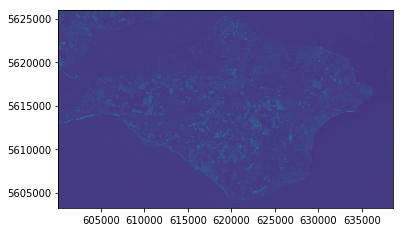

In [6]:
show(rgb[0], transform=mask_transform)

Update the meta data - see https://github.com/acgeospatial/Satellite_Imagery_Python/blob/master/Plotting%20Shapefiles%20and%20Rasters.ipynb for more information

In [7]:
profile = data.meta
print(profile)

WIDTH = rgb.shape[2] ## get the dimensions of the image we are writting out
HEIGHT = rgb.shape[1]

profile.update(count = 3, transform=mask_transform, height = HEIGHT, width = WIDTH)
print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7811, 'height': 7921, 'count': 1, 'crs': CRS.from_dict(init='epsg:32630'), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5688915.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1283, 'height': 758, 'count': 3, 'crs': CRS.from_dict(init='epsg:32630'), 'transform': Affine(30.0, 0.0, 600135.0,
       0.0, -30.0, 5626005.0)}


write out the clipped image

In [8]:
with rasterio.open('clipCOG_432.tif', 'w', **profile) as dst:
    dst.write(rgb)

check that it is a geotiff!

In [9]:
!gdalinfo clipCOG_432.tif

Driver: GTiff/GeoTIFF
Files: clipCOG_432.tif
Size is 1283, 758
Coordinate System is:
PROJCS["WGS 84 / UTM zone 30N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32630"]]
Origin = (600135.000000000000000,5626005.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image

Alternatively - if you want to plot the data as RGB in jupyter using matplotlib - we need to scale it. Look what happens when we plot the data currently

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


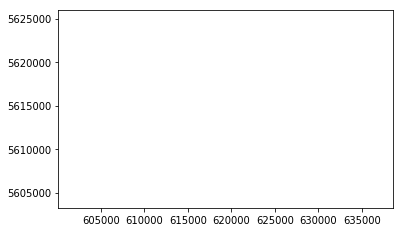

In [10]:
show(rgb, transform=mask_transform)

Lets change the read_imagery function. Many thanks to https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html for the code snippet

In [11]:
def read_imagery(path):
    data = rasterio.open(path)
    masked, mask_transform = mask(dataset=data, shapes=gdf.geometry, crop=True)
    print(masked.shape)
    masked_min, masked_max = masked[0,:,:].min(), masked[0,:,:].max()
    array = ((masked[0,:,:] - masked_min)/(masked_max - masked_min))
    return data, array, mask_transform

Lets create our RGB array again

In [12]:
lsarray=[]
for path in landsatband:
    data, masked, mask_transform = read_imagery(path)
    lsarray.append(masked)
    
rgb = np.stack(lsarray)

(1, 758, 1283)
(1, 758, 1283)
(1, 758, 1283)


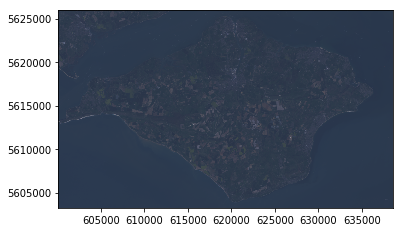

In [13]:
show(rgb, transform=mask_transform)

Its pretty faint we need to stretch this data using histogram equalixation in skimage

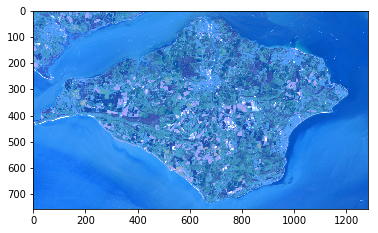

In [14]:
from skimage import exposure
img_eq = exposure.equalize_hist(rgb)
show(img_eq)